In [2]:
import numpy as np 
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, RandomizedSearchCV, KFold, cross_validate
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, ElasticNetCV, Lasso, LassoCV, LassoLarsIC, Ridge, RidgeCV, TweedieRegressor, BayesianRidge, LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import  RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p


# Setting plot styling.
plt.style.use('seaborn')

# Data Preparation
### Load Data 

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

full_data = pd.concat([train_df, test_df]).reset_index(drop=True)

print('train_df\t{}'.format(train_df.shape))
print('test_df \t{}'.format(test_df.shape))
print('full_data \t{}'.format(full_data.shape))

train_df.head()

train_df	(1460, 81)
test_df 	(1459, 80)
full_data 	(2919, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


5 rows × 81 columns

In [5]:
# Check different columns between train and test columns
set(train_df.columns) - set(test_df.columns)

{'SalePrice'}

In [6]:
# Drop columns 'Id'
train_df.drop(columns = 'Id', inplace=True)
test_df.drop(columns = 'Id', inplace=True)
full_data.drop(columns = 'Id', inplace=True)
print('Drop column Id completed')

Drop column Id completed


# Explore the data 
### Bivariate Analysis
First we have to understand overall data by take a quick look and visualize them easy to gain information.

### Check corralation

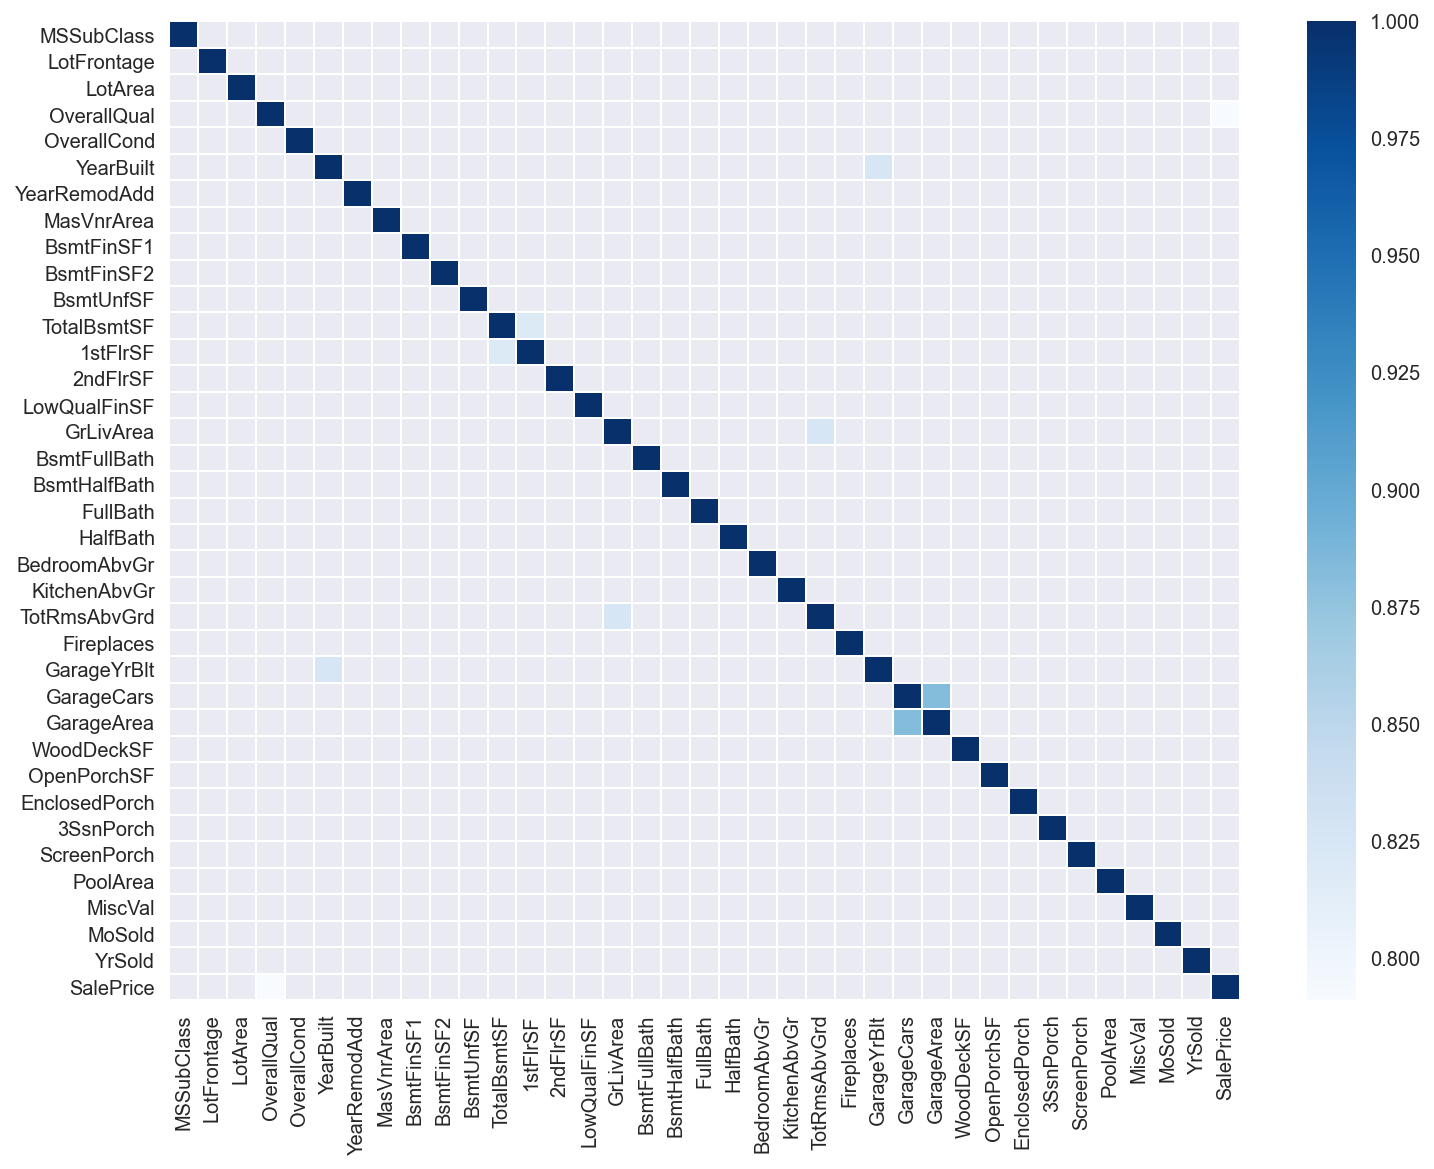

In [7]:
plt.subplots(figsize=(12,9))

corrmat = train_df.corr()
sns.heatmap(corrmat, mask = corrmat < 0.75, linewidth = 0.5, cmap = 'Blues');

### We will see the correlated variables which are linear relationship highly that might be multicollinearity.

Multicollinearity is a correlated with another independent variable in some case two or more other independent variables so that can reduce the performance of some algorithm. Estimates for regression coefficients can be unreliable and tests of significance for regression coefficients can be misleading.

As figure above there are some variable are correlate:

#### GarageYrBlt and YearBuilt
#### TotRmsAbvGrd and GrLivArea
#### 1stFlrSF and TotalBsmtSF
#### GarageArea and GarageCars

In [8]:
top_corr = abs(corrmat.SalePrice).sort_values(ascending=False).head(10)
top_corr_col = list(top_corr.index)
top_corr_col.remove('SalePrice')
top_corr

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

We would focus on the variables that are high correlation to target variable and then consider to eliminate outliers because they are values that are notably different from other data points, and they can cause problems like miss significant findings or distort real results.

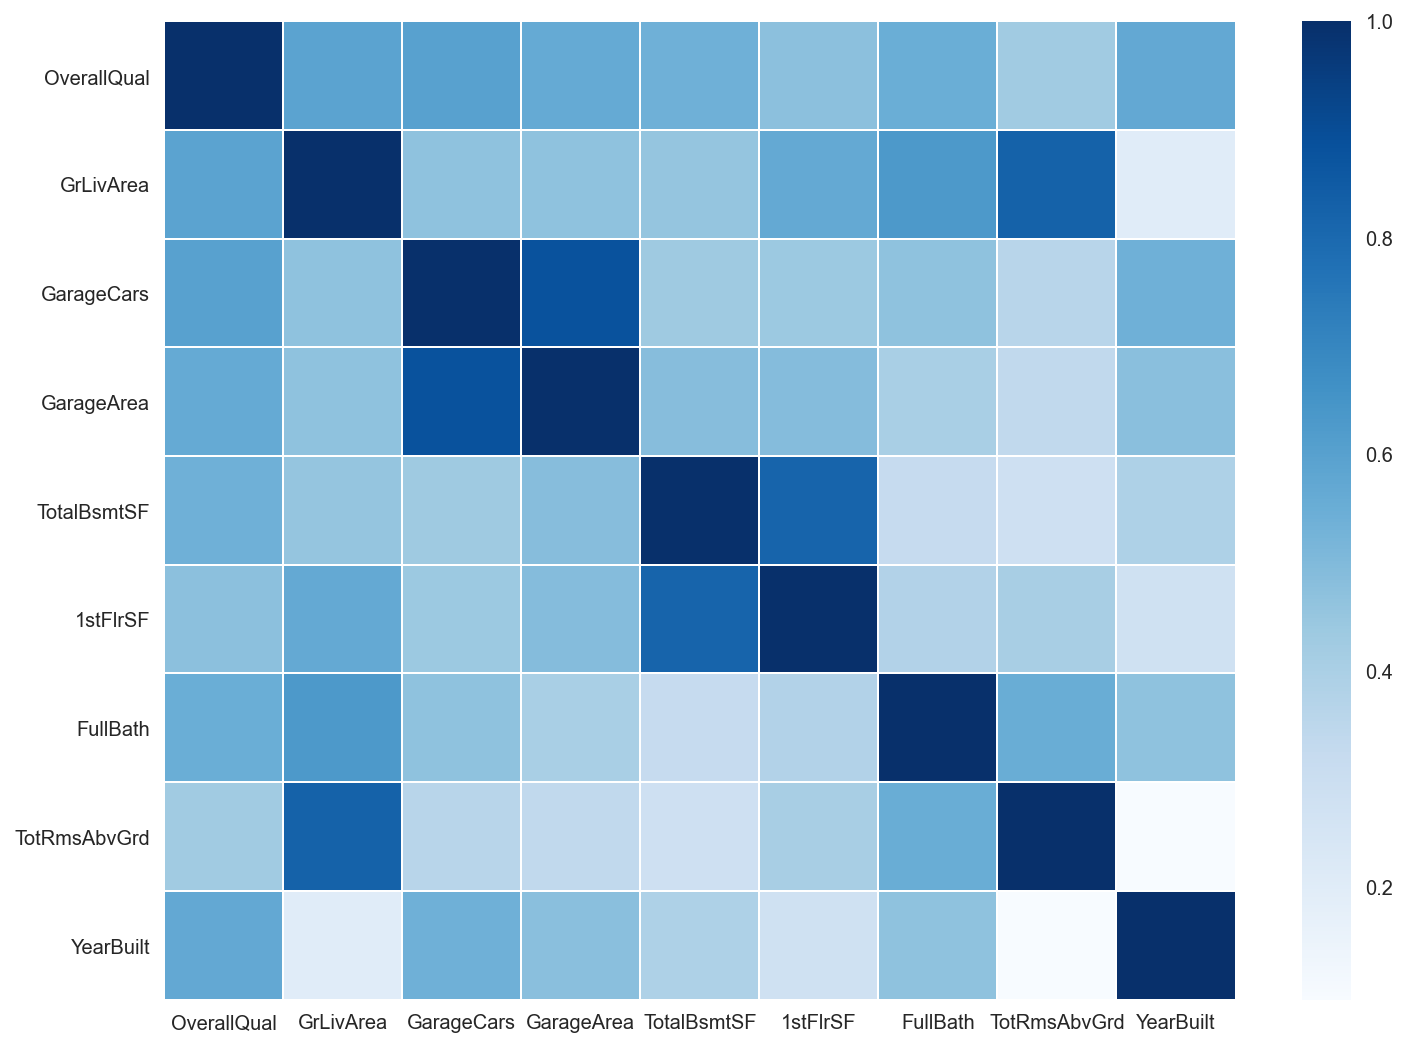

In [9]:
plt.subplots(figsize=(12,9))

corrmat = train_df[top_corr_col].corr()
sns.heatmap(corrmat, linewidth = 0.5, cmap = 'Blues');

In [10]:
# Plot variable vs target variable(SalePrice)
def plot_(df, col):
    if df[col].dtype != 'object':
        if len(df[col].unique()) <= 12:
            fig, ax = plt.subplots(1,2,figsize=(12,6))
            sns.stripplot(x=col, y='SalePrice', alpha = 0.5, data=df, ax=ax[0])
            sns.countplot(df[col], ax=ax[1])
            fig.suptitle(str(col) + ' analysis')
        else:
            fig, ax = plt.subplots(1,2,figsize=(12,6))
            sns.scatterplot(x=col, y='SalePrice', alpha = 0.5, data=df, ax=ax[0])
            sns.distplot(df[col], kde=False, ax=ax[1])
            fig.suptitle(str(col) + ' analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6), sharey=True)
        sns.stripplot(x=col, y='SalePrice', alpha = 0.5, data=df, ax=ax[0])
        sns.boxplot(x=col, y='SalePrice', data=df, ax=ax[1])
        fig.suptitle(str(col) + ' analysis')
        
# Explore missing data
def plot_missing(df):
    miss_col = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)
    percent_miss = round((miss_col / len(df) *100),2)
    missing = pd.DataFrame([miss_col, percent_miss]).T.rename(columns = {0:'Feature', 1:'% missing'})
    return missing

# Sort category vs target variable
def sort_cate(df, col, target="SalePrice"):
    
    
    print("{}  | type: {}\n".format(col, df[col].dtype))
    d = pd.DataFrame({"n": df[col].value_counts(),
                                "Ratio": 100 * df[col].value_counts() / len(df),
                                "TARGET_MEDIAN": df.groupby(col)[target].median(),
                                "Target_MEAN": df.groupby(col)[target].mean()}).sort_values(by='TARGET_MEDIAN', ascending=False)
    print(d, end="\n\n")
    
    fig, ax = plt.subplots(1,2,figsize=(20,6), sharey=True)
    sns.stripplot(x=col, y='SalePrice', data=df, alpha = 0.5, order = d.index,  ax=ax[0])

    sns.boxplot(x=col, y='SalePrice', data=df, order = d.index, ax=ax[1])
    fig.suptitle(str(col) + ' analysis')
    
    fig.autofmt_xdate(rotation=45)
#     plt.xticks(rotation=45)
#     set_xticklabels(chart.get_xticklabels(ax=ax[1]), rotation=45, horizontalalignment='right')
    plt.show();

print('Plot functions are ready to use')

Plot functions are ready to use


Neighborhood  | type: object

           n      Ratio  TARGET_MEDIAN    Target_MEAN
NridgHt   77   5.273973         315000  316270.623377
NoRidge   41   2.808219         301500  335295.317073
StoneBr   25   1.712329         278000  310499.000000
Timber    38   2.602740         228475  242247.447368
Somerst   86   5.890411         225500  225379.837209
Veenker   11   0.753425         218000  238772.727273
Crawfor   51   3.493151         200624  210624.725490
ClearCr   28   1.917808         200250  212565.428571
CollgCr  150  10.273973         197200  197965.773333
Blmngtn   17   1.164384         191000  194870.882353
NWAmes    73   5.000000         182900  189050.068493
Gilbert   79   5.410959         181000  192854.506329
SawyerW   59   4.041096         179900  186555.796610
Mitchel   49   3.356164         153500  156270.122449
NPkVill    9   0.616438         146000  142694.444444
NAmes    225  15.410959         140000  145847.080000
SWISU     25   1.712329         139500  142591.36000

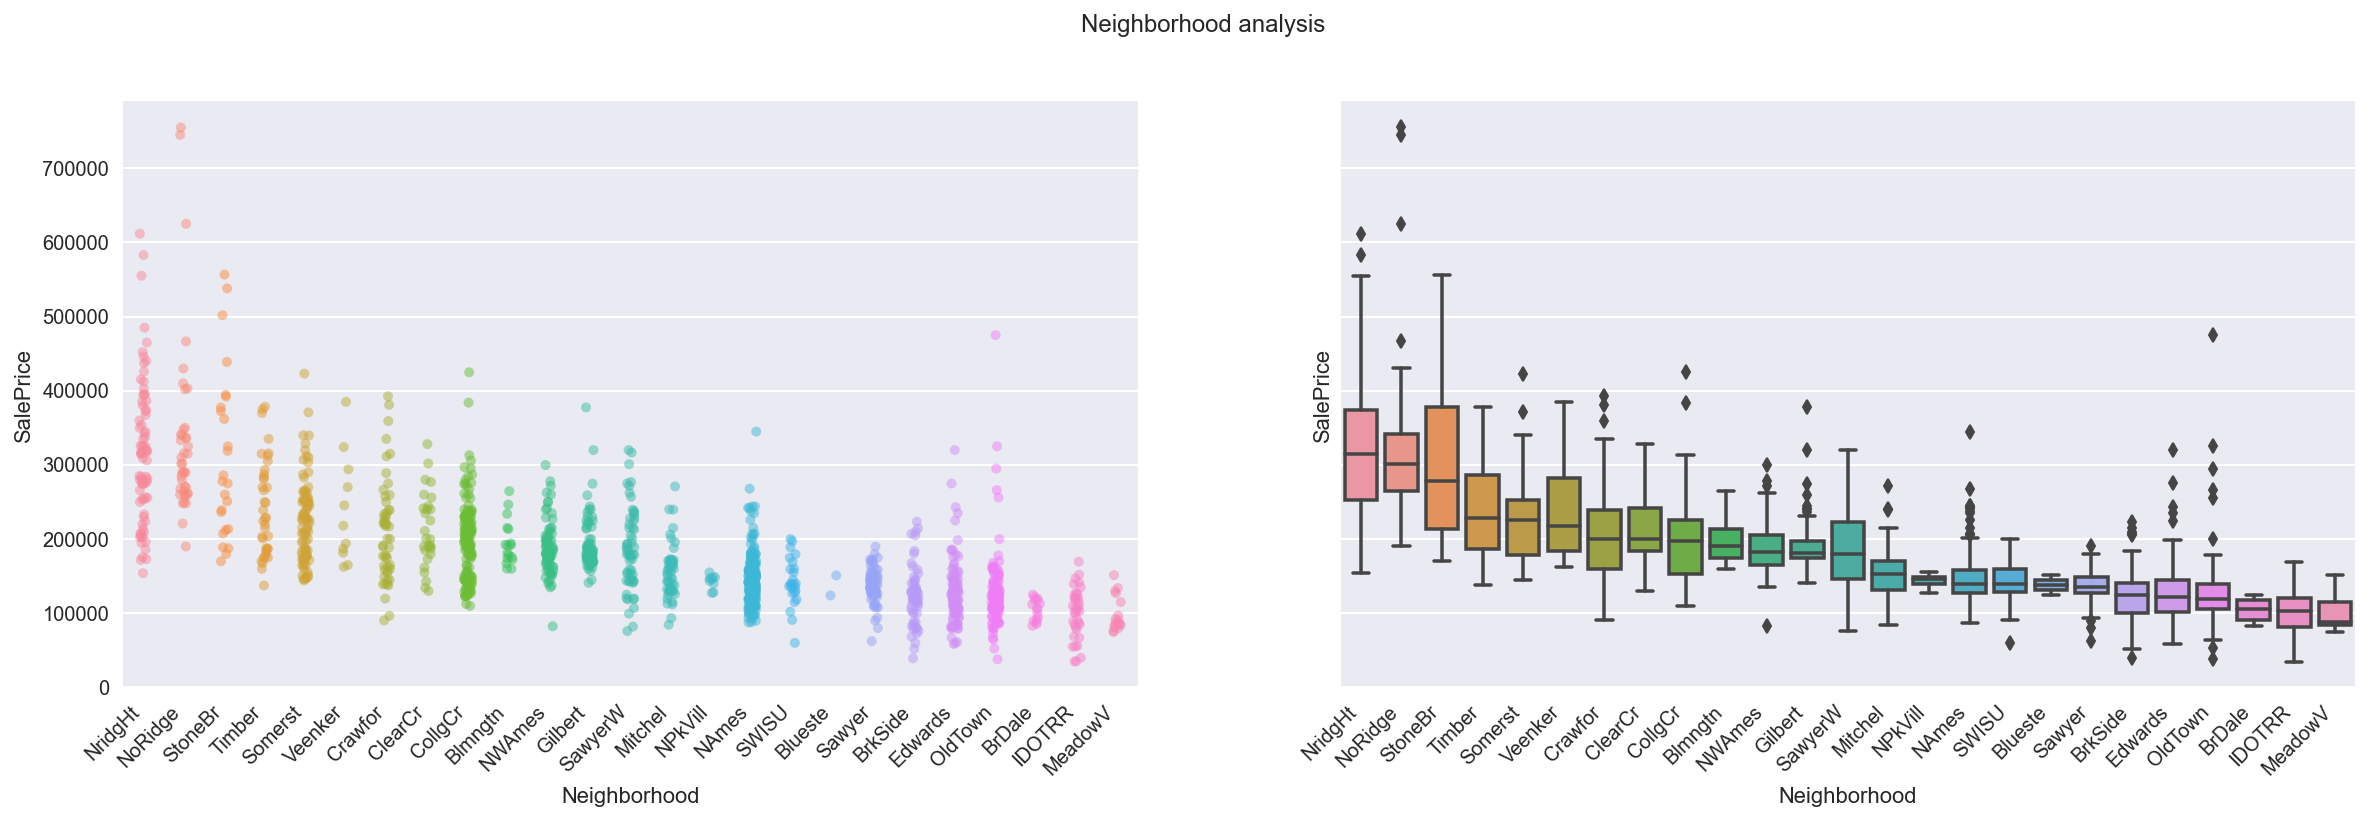

In [11]:
sort_cate(train_df, 'Neighborhood')

# Data Preprocessing 
### Dealing with Outlierss 
There are some data points that are far from other data points. We would remove outliers which are problematic for many statistical analyses because they can distort real results.

In [12]:
train_df = train_df.drop(train_df[(train_df['OverallQual'] < 5) & (train_df['SalePrice'] > 200000)].index)
train_df = train_df.drop(train_df[(train_df['OverallQual'] > 9) & (train_df['SalePrice'] < 200000)].index)


train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['GarageArea'] > 1200) & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['TotalBsmtSF'] > 3000) & (train_df['SalePrice'] < 200000)].index)

train_df = train_df.drop(train_df[(train_df['1stFlrSF'] > 3000) & (train_df['SalePrice'] < 200000)].index)

### Target Variable (SalePrice)

Skewness:  1.88
Kurtosis:  6.53


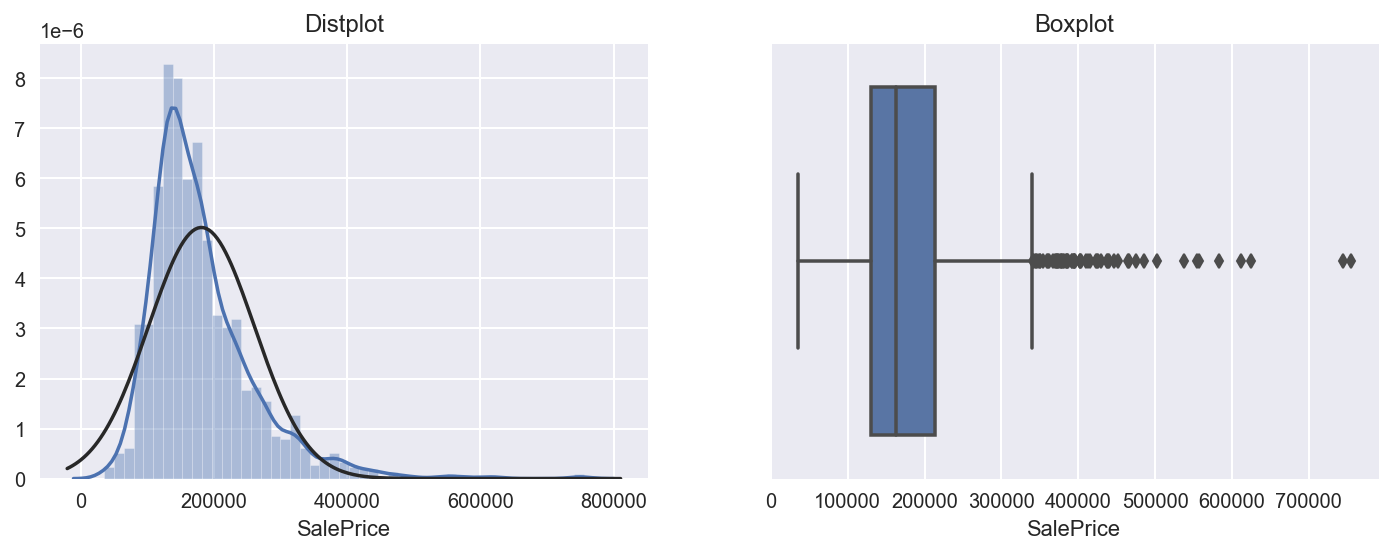

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))

ax1.set_title('Distplot')
sns.distplot(train_df['SalePrice'], fit=norm,  ax = ax1)

ax2.set_title('Boxplot')
sns.boxplot(train_df['SalePrice'], ax = ax2)


print ('Skewness: ', np.round(train_df['SalePrice'].skew(), 2))
print ('Kurtosis: ', np.round(train_df['SalePrice'].kurt(), 2))

Target variable is a positive skewness, so we need to transform data by Log-transformation of the target variable.

Skewness:  0.12
Kurtosis:  0.81


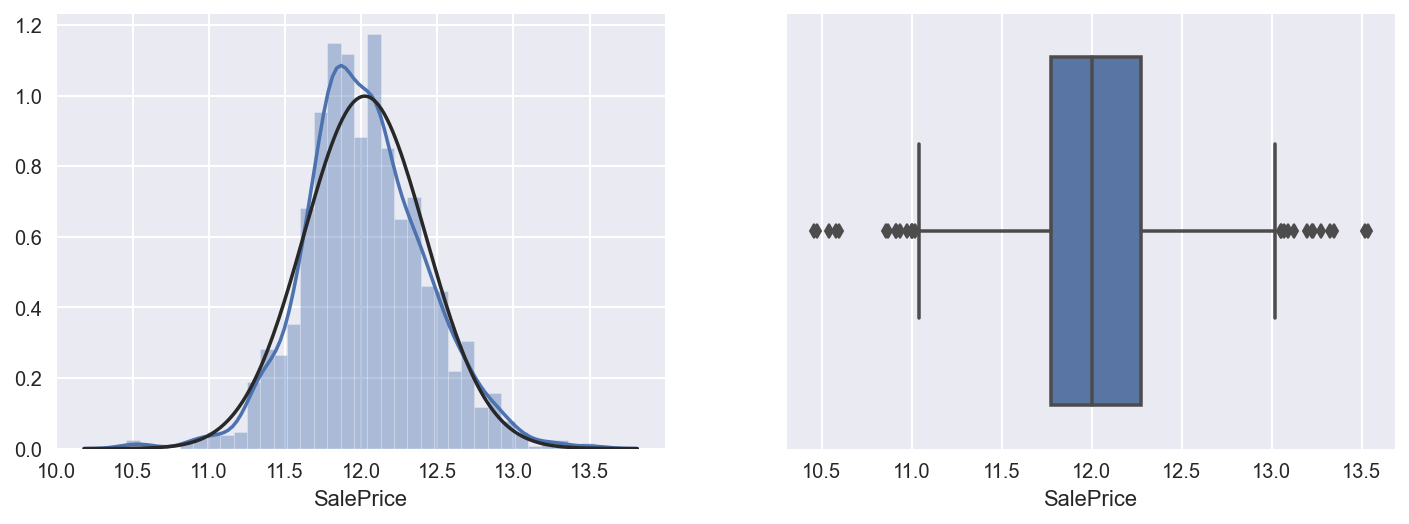

In [14]:
# Apply log(1+x) in order to transform target variable
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax1.set_title('Distplot Log-transformation')
sns.distplot(train_df['SalePrice'],fit=norm,  ax = ax[0])

ax2.set_title('Boxplot Log-transformation')
sns.boxplot(train_df['SalePrice'], ax = ax[1])

print ('Skewness: ', np.round(train_df['SalePrice'].skew(), 2))
print ('Kurtosis: ', np.round(train_df['SalePrice'].kurt(), 2))

# Missing Value 

In [15]:
plot_missing(test_df)

,Feature,% missing
PoolQC,1456.0,99.79
MiscFeature,1408.0,96.50
Alley,1352.0,92.67
Fence,1169.0,80.12
FireplaceQu,730.0,50.03
LotFrontage,227.0,15.56
GarageYrBlt,78.0,5.35
GarageCond,78.0,5.35
GarageQual,78.0,5.35
GarageFinish,78.0,5.35


For some feature such as PoolQC, MiscFeature and Alley there are moer than 90% of missing value but in this case NaN mean No Pool, No Miscellaneous and No alley access.

We will replace NaN with 'None' and for the other features we would take into account and impute NaN to the following column.

In [16]:
none_cols = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
             'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
             'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

# Impute missing value
for col in none_cols:
    train_df[col].replace(np.nan, 'None', inplace=True)
    test_df[col].replace(np.nan, 'None', inplace=True)

For other features such as BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath all of these are numerical features if No basement that should be replaced with 0.

In [17]:
bsm=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath','BsmtQual']
train_df[bsm].groupby('BsmtQual').sum()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
BsmtQual,,,,,,
Ex,95591,2851,91428,189870,79,6
Fa,4575,276,20805,25656,6,2
Gd,290890,21417,385330,697637,293,27
None,0,0,0,0,0,0
TA,246479,43418,328032,617929,238,49


Like if No Garage GarageYrBlt, GarageArea, GarageCars should be replaced with 0 also.

In [18]:
gar = ['GarageYrBlt', 'GarageArea', 'GarageCars','GarageQual']
train_df[gar].groupby('GarageQual').sum()

,GarageYrBlt,GarageArea,GarageCars
GarageQual,,,
Ex,5967.0,2064,5
Fa,92817.0,14946,65
Gd,27733.0,7800,26
None,0.0,0,0
Po,5756.0,978,3
TA,2586149.0,659328,2467


In [19]:
# Replace these features by 0 
zero_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']

for col in zero_cols:
    train_df[col].replace(np.nan, 0, inplace=True)
    test_df[col].replace(np.nan, 0, inplace=True)

In [20]:
# Replace these features by most frequency value or mode
most_freq_cols = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual','SaleType', 'Utilities']

for col in most_freq_cols:
    train_df[col].replace(np.nan, train_df[col].mode()[0], inplace=True)
    test_df[col].replace(np.nan, test_df[col].mode()[0], inplace=True)

MSZoning should be considered to replace NaN by gruop of MSSubClass

LotFrontage relate to Neighborhood so we will replace NaN by gruop of Neighborhood

For MSSubClass, YrSold, MoSold should be change to str

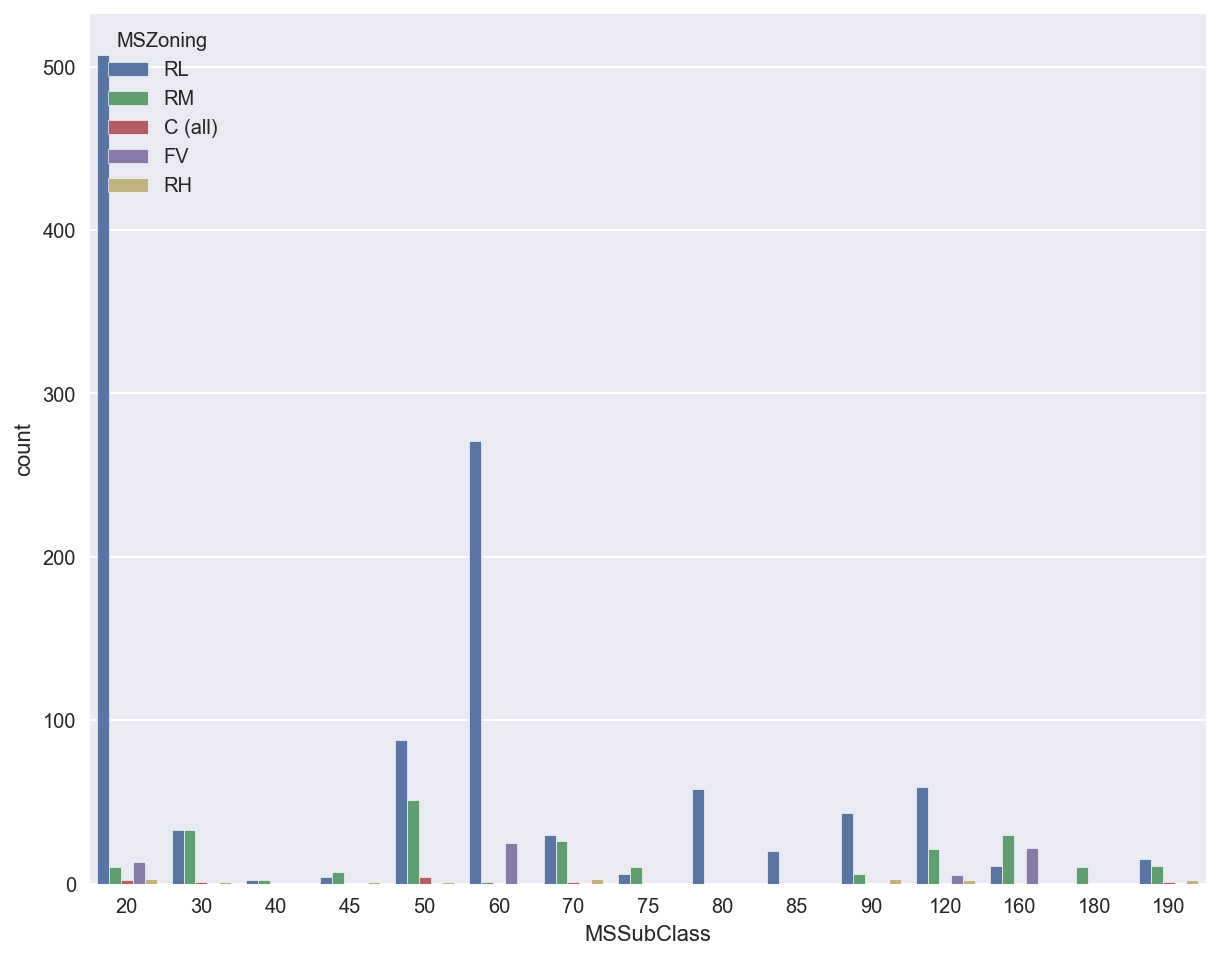

In [21]:
fig, ax = plt.subplots(1,1,figsize = (10, 8))
sns.countplot(x="MSSubClass", hue="MSZoning", data=train_df);

In [22]:
train_df['MSZoning'] = train_df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))
test_df['MSZoning'] = test_df.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))


train_df["LotFrontage"] = train_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_df["LotFrontage"] = test_df.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


# Change type to str
chg_type = ['MSSubClass', 'YrSold', 'MoSold']
train_df[chg_type] = train_df[chg_type].astype(str)
test_df[chg_type] = test_df[chg_type].astype(str)

Neighborhood  | type: object

           n      Ratio  TARGET_MEDIAN  Target_MEAN
NridgHt   77   5.292096      12.660331    12.619415
NoRidge   41   2.817869      12.616529    12.676003
StoneBr   25   1.718213      12.535380    12.585490
Timber    38   2.611684      12.339184    12.363460
Somerst   86   5.910653      12.326077    12.296500
Veenker   11   0.756014      12.292255    12.344180
Crawfor   51   3.505155      12.209193    12.206664
ClearCr   27   1.855670      12.206078    12.232015
CollgCr  150  10.309278      12.191972    12.163647
Blmngtn   17   1.168385      12.160034    12.169421
NWAmes    73   5.017182      12.116700    12.130614
Gilbert   79   5.429553      12.106258    12.155809
SawyerW   59   4.054983      12.100162    12.090695
Mitchel   48   3.298969      11.932921    11.931917
NPkVill    9   0.618557      11.891369    11.866484
NAmes    225  15.463918      11.849405    11.868052
SWISU     25   1.718213      11.845827    11.838442
Blueste    2   0.137457      11.82

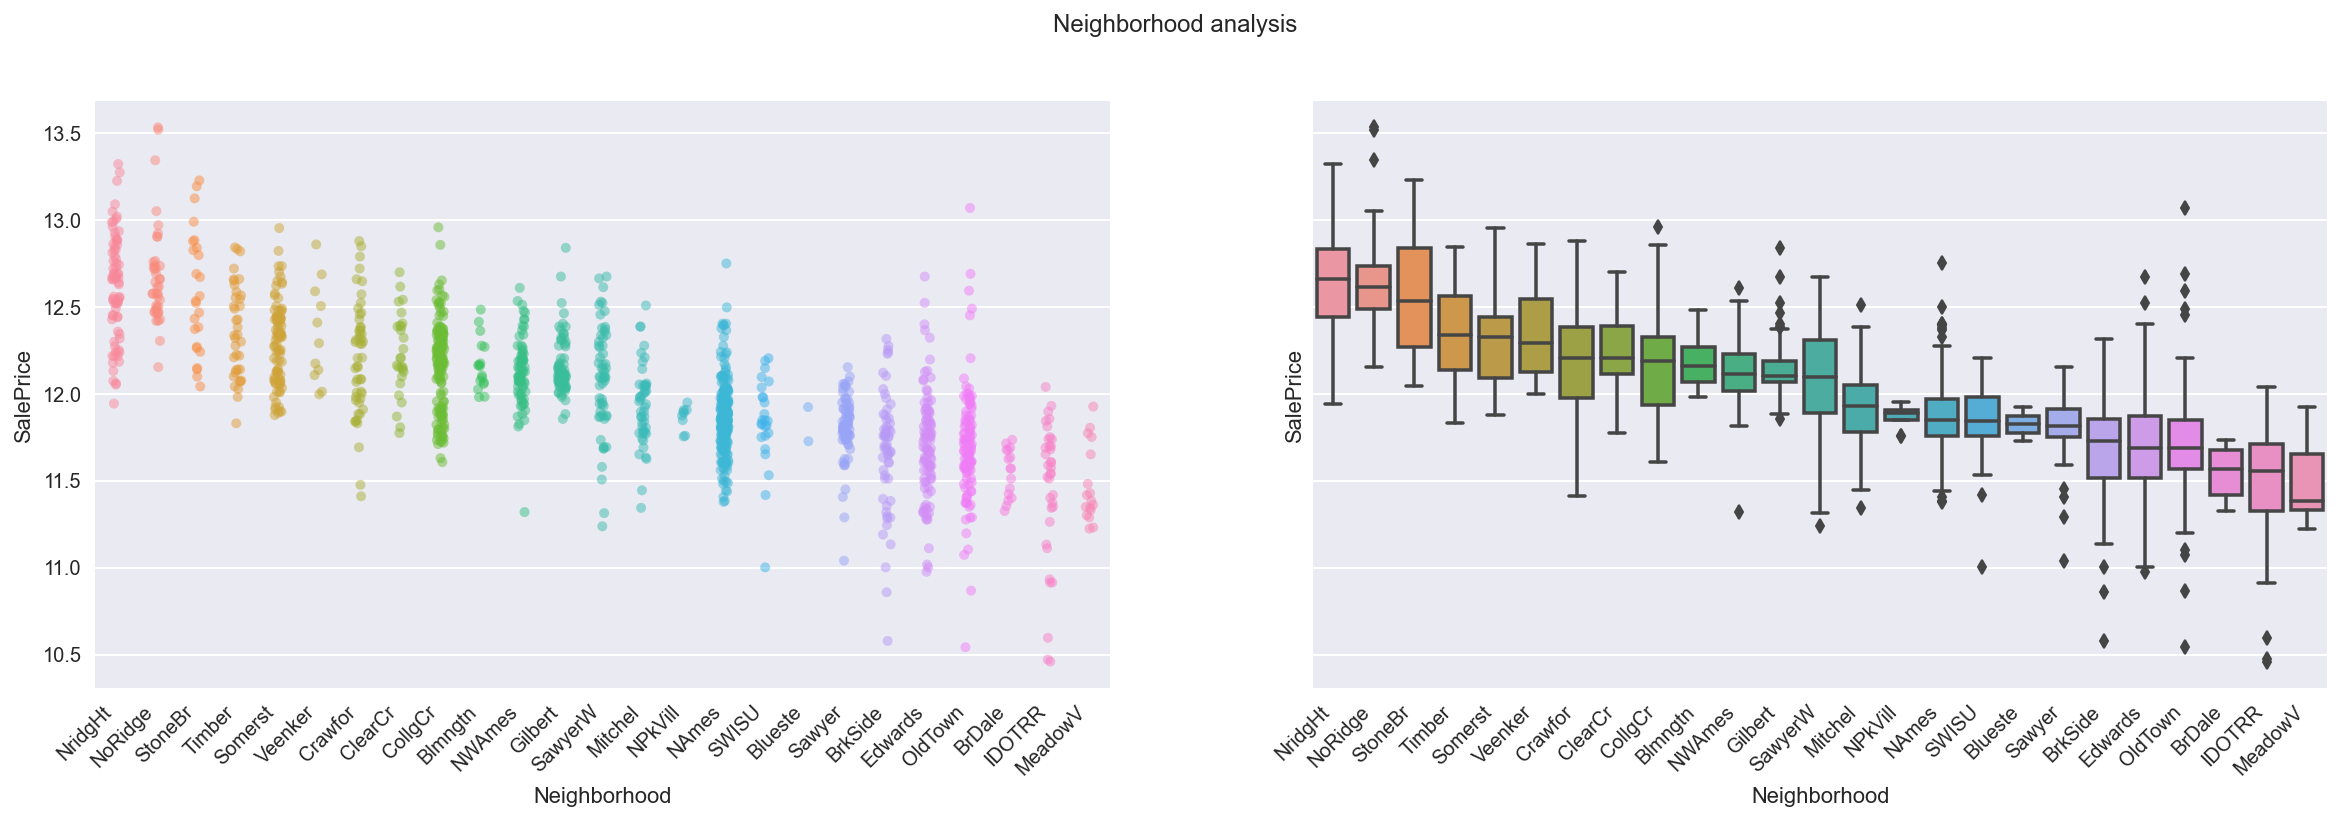

In [23]:
sort_cate(train_df, 'Neighborhood')

In [24]:
# Transform categorical to ordinal features
def cate_to_ordinal(df):
    
    n_map = {'MeadowV': 1,'IDOTRR': 1,'BrDale': 1,'OldTown': 2,'Edwards': 2,'BrkSide': 2,
                 'Sawyer': 3,'Blueste': 3,'SWISU': 3,'NPkVill': 3,'NAmes': 3,'Mitchel': 4,
                 'SawyerW': 5,'NWAmes': 5,'Gilbert': 5,'Blmngtn': 5,'CollgCr': 5,
                 'ClearCr': 6,'Crawfor': 6,'Veenker': 7,'Somerst': 7,'Timber': 7,
                 'StoneBr': 8,'NoRidge': 9,'NridgHt': 10}
    df['Neighborhood'] = df['Neighborhood'].map(n_map).astype('int')

    ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['ExterQual'] = df['ExterQual'].map(ext_map).astype('int')

    ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['ExterCond'] = df['ExterCond'].map(ext_map).astype('int')

    bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['BsmtQual'] = df['BsmtQual'].map(bsm_map).astype('int')
    df['BsmtCond'] = df['BsmtCond'].map(bsm_map).astype('int')

    bsmf_map = {'None': 0,'Unf': 1,'LwQ': 2,'Rec': 3,'BLQ': 4,'ALQ': 5,'GLQ': 6}
    df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmf_map).astype('int')
    df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmf_map).astype('int')

    heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    df['HeatingQC'] = df['HeatingQC'].map(heat_map).astype('int')
    df['KitchenQual'] = df['KitchenQual'].map(heat_map).astype('int')
    df['FireplaceQu'] = df['FireplaceQu'].map(bsm_map).astype('int')
    df['GarageCond'] = df['GarageCond'].map(bsm_map).astype('int')
    df['GarageQual'] = df['GarageQual'].map(bsm_map).astype('int')
    
cate_to_ordinal(train_df)
cate_to_ordinal(test_df)

# Feature Engineering 

We would create useful new features from existing feature in order to add more information to target variable.

In [25]:
train_df['TotalSF'] = train_df['BsmtFinSF1'] + train_df['BsmtFinSF2'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

test_df['TotalSF'] = test_df['BsmtFinSF1'] + test_df['BsmtFinSF2'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']

If the values of a certain independent variable (feature) are skewed, depending on the model, skewness may violate model assumptions (e.g. logistic regression) or may impair the interpretation of feature importance. In this case we will use Boxcox-Transformation to transform high skewness features

In [26]:
num_col = list(train_df.select_dtypes(exclude='object').columns)
num_col.remove('SalePrice')

# Get skewness of numerical feature
skew_feature = abs(train_df[num_col].apply(lambda x: skew(x))).sort_values(ascending = False)

# Filter feature that has skewness > 0.75 
high_skew = skew_feature[skew_feature > 0.75]

# Transform by using Boxcox-Transformation

for f in high_skew.index:
    train_df[f] = boxcox1p(train_df[f], boxcox_normmax(train_df[f] + 1))
    test_df[f] = boxcox1p(test_df[f], boxcox_normmax(test_df[f] + 1))

In [27]:
train_df['Utilities'].value_counts(normalize = True).iloc[0]

0.9993127147766323

In [28]:
thd = 0.95
drop_col = []

for column in train_df.drop('SalePrice', axis = 1):
    
    most_freq_value = train_df[column].value_counts(normalize = True).iloc[0]
    if most_freq_value > thd:
        drop_col.append(column)
        print ('{}: \t {}% same value'.format(column, np.round(most_freq_value, 3)))

Street: 	 0.997% same value
Utilities: 	 0.999% same value
Condition2: 	 0.99% same value
RoofMatl: 	 0.984% same value
Heating: 	 0.978% same value
LowQualFinSF: 	 0.982% same value
KitchenAbvGr: 	 0.953% same value
3SsnPorch: 	 0.984% same value
PoolArea: 	 0.996% same value
PoolQC: 	 0.996% same value
MiscFeature: 	 0.964% same value
MiscVal: 	 0.965% same value


In [29]:
drop_col += ['GarageYrBlt','TotRmsAbvGrd', '1stFlrSF', 'GarageCars']
# Drop column
train_df.drop(columns = drop_col, inplace=True)
test_df.drop(columns = drop_col, inplace=True)

print ('Drop Columns Completed')

Drop Columns Completed


In [30]:
y_train = train_df['SalePrice']
train_X = train_df.drop(columns = 'SalePrice')

print ('Splitting "SalePrice" Completed')

Splitting "SalePrice" Completed


In [32]:
from sklearn.preprocessing import OneHotEncoder

# Get categorical columns
cat_col = train_X.select_dtypes(include='object').columns
num_col = train_X.select_dtypes(exclude='object').columns

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)

# Apply one-hot encoder to each column with categorical data
OH_cols_train = pd.DataFrame(enc.fit_transform(train_X[cat_col]))
OH_cols_test = pd.DataFrame(enc.transform(test_df[cat_col]))

# One-hot encoding removed index; put it back
OH_cols_train.index = train_X.index
OH_cols_test.index = test_df.index

# Put columns name into One-hot encoding columns
OH_cols_train.columns = enc.get_feature_names(cat_col)
OH_cols_test.columns = enc.get_feature_names(cat_col)

# Concat Categorical with Numerical columns
X_train = pd.concat([train_X[num_col], OH_cols_train], axis=1)
X_test = pd.concat([test_df[num_col], OH_cols_test], axis=1)

# Modeling 

In [33]:
# Basic LinearRegression

print('='*30 +'BASE MODEL' + '='*30)
slr = LinearRegression()
slr.fit(X_train, y_train)
print('slope ： {:0.2f}'.format(slr.coef_[0]))
print('intercept : {:0.2f}'.format(slr.intercept_))
print('\n')
y_pre = slr.predict(X_train)
y_test = slr.predict(X_test)
RMSE = -1*cross_val_score(slr, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
print(f'RMSE: {RMSE}')

==============================BASE MODEL==============================
slope ： 0.00
intercept : 4.32


RMSE: 0.12067643161151342


==============================RMSE BASE MODEL==============================
LinearRegression          0.12068 ±0.006
Ridge                     0.11665 ±0.006
Lasso                     0.18666 ±0.005
ElasticNet                0.18043 ±0.003
RandomForestRegressor     0.13387 ±0.004


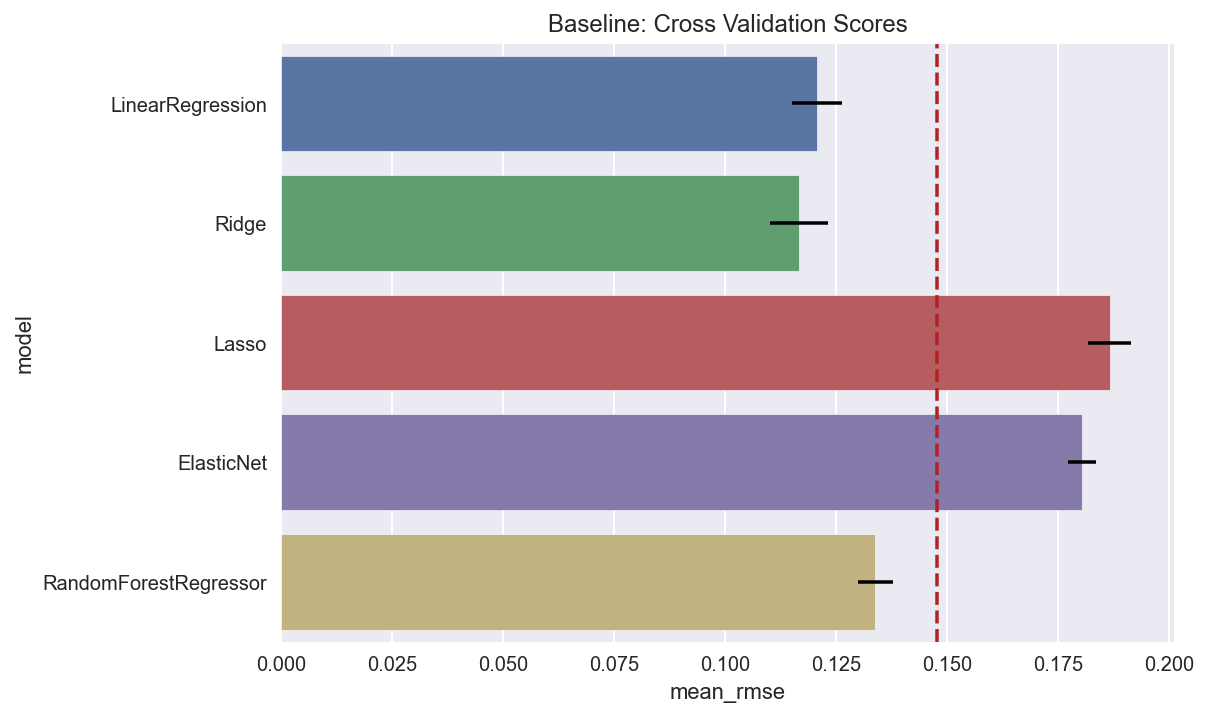

In [34]:
models = [('LinearRegression', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('RandomForestRegressor', RandomForestRegressor())]

print('='*30 +'RMSE BASE MODEL' + '='*30)

mean_rmse = []
sd_rmse = []
model_name = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = -1*cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{name:<25} {RMSE.mean():.5f} ±{RMSE.std():.3f}')
    
    mean_rmse.append(RMSE.mean())
    sd_rmse.append(RMSE.std())
    model_name.append(name)

    
base = pd.DataFrame({'model':model_name, 'mean_rmse':mean_rmse, 'sd_rmse':sd_rmse})
sns.barplot(x="mean_rmse", y="model", data=base, orient = 'h',**{'xerr': sd_rmse})
plt.title('Baseline: Cross Validation Scores')
plt.axvline(x = np.mean(mean_rmse), color = 'firebrick', linestyle = '--');

# Hyperparameters Tuning 

In [35]:
# Ridge
pipe = make_pipeline(RobustScaler(), Ridge())

param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 15 ,20, 25, 30]}

grid_rid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_rid = grid_rid.fit(X_train, y_train)

rid_param = best_grid_rid.best_params_

print(f'best_params_: {rid_param}')
print(f'score: {-1*best_grid_rid.best_score_:.5f}')

best_params_: {'ridge__alpha': 25}
score: 0.11316


In [36]:
# Lasso
pipe = make_pipeline(Lasso())

param_grid = {'lasso__alpha': [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008],
              'lasso__max_iter': [1e3, 1e5, 1e7]}

grid_las = GridSearchCV(pipe, param_grid = param_grid, cv = 5, scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_las = grid_las.fit(X_train, y_train)

las_param = best_grid_las.best_params_

print(f'best_params_: {las_param}')
print(f'score: {-1*best_grid_las.best_score_:.5f}')

best_params_: {'lasso__alpha': 0.0004, 'lasso__max_iter': 1000.0}
score: 0.11141


In [37]:
# ElasticNet
pipe = make_pipeline(ElasticNet())

param_grid = {'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1], # constant that multiplies the penalty terms, default = 1.0
              'elasticnet__l1_ratio': [0.25, 0.5, 0.75]} # the mixing parameter, default = 0.5

grid_en = GridSearchCV(pipe, param_grid = param_grid, cv = 5,scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_en = grid_en.fit(X_train, y_train)

en_param = best_grid_en.best_params_

print(f'best_params_: {en_param}')
print(f'score: {-1*best_grid_en.best_score_:.5f}')

best_params_: {'elasticnet__alpha': 0.001, 'elasticnet__l1_ratio': 0.5}
score: 0.11158


In [38]:
# RandomForestRegressor
rf = RandomForestRegressor()

param_grid = {'bootstrap': [True, False],
             'max_depth': [10, 25, 50],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 3],
             'min_samples_split': [2, 3],
             'n_estimators': [300,500]
             }

grid_rf = RandomizedSearchCV(rf, param_distributions = param_grid, cv = 5,scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_rf = grid_rf.fit(X_train, y_train)

rf_param = best_grid_rf.best_params_

print(f'best_params_: {rf_param}')
print(f'score: {-1*best_grid_rf.best_score_:.5f}')

best_params_: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False}
score: 0.13225


In [47]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [51]:
from xgboost import XGBRegressor

In [55]:
# XGBRegressor
xgb = XGBRegressor()

param_grid = {'learning_rate' : [0.01, 0.1, 0.5], # Boosting learning rate
              'n_estimators' : [200],       # Number of gradient boosted trees
              'max_depth' : [3, 6, 10],     # Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
              'min_child_weight' : [1, 5, 10],  # Increasing this value will make model more conservative.
              'reg_alpha' : [0.01, 0.1, 1],  # Increasing this value will make model more conservative.
              'reg_lambda' : [0.01, 0.1, 1]}  # Increasing this value will make model more conservative.

grid_xgb = RandomizedSearchCV(xgb, param_distributions = param_grid, cv = 5,scoring = 'neg_root_mean_squared_error', verbose = False, n_jobs = -1)

best_grid_xgb = grid_xgb.fit(X_train, y_train)

xgb_param = best_grid_xgb.best_params_

print(f'best_params_: {xgb_param}')
print(f'score: {-1*best_grid_xgb.best_score_:.5f}')

best_params_: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.1}
score: 0.12135


In [57]:
svr_scores = cross_val_score(best_grid_en.best_estimator_, X_train, y_train,
                             cv=5, n_jobs=-1, error_score="neg_root_mean_squared_error")

svr_scores.mean()

0.9214997422665896

## Ensemble Algorithms
We use Stacking is an ensemble learning technique to combine multiple regression models via a meta-regressor. In this case we use XGBRegressor as meta-regressor.

In [60]:
stack = StackingCVRegressor(regressors = (best_grid_en.best_estimator_,
                                          best_grid_rid.best_estimator_,
                                          best_grid_las.best_estimator_,
                                          best_grid_rf.best_estimator_,
                                          
                            use_features_in_secondary = True)


stack.fit(X_train, y_train);

stack_score = -cross_val_score(stack, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5)

print(f'score: {stack_score.mean():.5f} ±{stack_score.std():.4f}')

SyntaxError: invalid syntax (<ipython-input-60-3e62f4ebd306>, line 6)

In [61]:
models = [("Ridge", best_grid_rid.best_estimator_),
          ("Lasso", best_grid_las.best_estimator_),
          ("ElasticNet", best_grid_en.best_estimator_),
          ('RandomForest', best_grid_rf.best_estimator_),]

print('='*30 +'RMSE TUNE MODEL' + '='*30)

mean_rmse = []
sd_rmse = []
model_name = []
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    RMSE = -1*cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print(f'{name:<25} {RMSE.mean():.5f} ±{RMSE.std():.3f}')
    
    mean_rmse.append(RMSE.mean())
    sd_rmse.append(RMSE.std())
    model_name.append(name)

mean_rmse.append(stack_score.mean())
sd_rmse.append(stack_score.std())
model_name.append('Stacking')

tune = pd.DataFrame({'model':model_name, 'mean_rmse':mean_rmse, 'sd_rmse':sd_rmse})


sns.barplot(x="mean_rmse", y="model", data=tune, orient = 'h',**{'xerr': sd_rmse})
plt.title('TUNE: Cross Validation Scores')
plt.axvline(x = np.mean(mean_rmse), color = 'firebrick', linestyle = '--');


==============================RMSE TUNE MODEL==============================
Ridge                     0.11316 ±0.006
Lasso                     0.11141 ±0.006
ElasticNet                0.11158 ±0.005
RandomForest              0.13226 ±0.008


NameError: name 'stack_score' is not defined